In [1]:
import dask
import dask.array as da
import xarray as xr
import rioxarray as rx
import rasterio
from shapely.geometry import shape
import geopandas as gpd
import pandas as pd
import cftime
import matplotlib.pyplot as plt
from xrspatial.zonal import stats as zonal_stats
from xrspatial.zonal import crosstab as zonal_crosstab
from geocube.api.core import make_geocube
import rasterio
from rasterio.plot import show
import numpy as np

In [2]:
ind2018_nc = './netcdf_files/RF25_ind2018_rfp25.nc'
geojson_path = 'kerala_boundary.geojson'
kerala_districts = 'district.geojson'
# Define the WGS84 CRS
wgs84_crs = "+proj=longlat +datum=WGS84 +no_defs"

In [42]:
# Open the NetCDF file using rioxarray
imd_daily_2018 = rx.open_rasterio(ind2018_nc, masked=True)

In [44]:
imd_daily_2018.rio.write_crs(wgs84_crs,inplace=True)
imd_daily_2018.rio.crs

CRS.from_wkt('GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

In [3]:
gdf = gpd.read_file(geojson_path)
district_gdf = gpd.read_file(kerala_districts)
geometry = shape(gdf.geometry.iloc[0])

In [ ]:
# Clip the rioxarray dataset using the mask
clipped_imd_daily = imd_ds.rio.clip([geometry], drop =True)
# If you want to save the result to a new file
clipped_imd_daily.to_netcdf('kerala_imd_daily_2018.nc')

In [4]:
imd_kerala_2018 = './netcdf_files/kerala_imd_daily_2018.nc'
# Open the NetCDF file using rioxarray
kerala_imd_ds = rx.open_rasterio(imd_kerala_2018, masked=True,chunks={'TIME': 'auto'})
datetimeindex = kerala_imd_ds.indexes['TIME'].to_datetimeindex()
kerala_imd_ds['TIME'] = datetimeindex

In [5]:
kerala_imd_monthly_2018 = kerala_imd_ds.groupby('TIME.month').sum(dim='TIME')

In [6]:
# Replace all 0 values with NaN
kerala_imd_monthly_2018 = kerala_imd_monthly_2018.where(kerala_imd_monthly_2018 != 0)

In [7]:
kerala_imd_monthly_2018_flatten = kerala_imd_monthly_2018.mean(dim=['x', 'y'], skipna=True)

In [8]:
kerala_imd_monthly_pd = kerala_imd_monthly_2018_flatten.to_dataframe()

In [9]:
kerala_imd_monthly_pd

,spatial_ref,RAINFALL
month,,
1,0,3.719451
2,0,19.981022
3,0,54.960645
4,0,114.122547
5,0,310.928115
6,0,658.691949
7,0,791.839522
8,0,810.825826
9,0,110.913762


In [10]:
x_values = kerala_imd_monthly_pd.index
#x_values = date2num(x_values)
y1_values =  kerala_imd_monthly_pd['RAINFALL']
#y2_values = kerala_monthly_mean_pd['RAINFALL']
bar_width = 5.0

In [12]:
file_path = 'kerala_precip.csv'
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)


In [35]:
y2_values = df[:1].values.tolist()[0][2:][:-1]

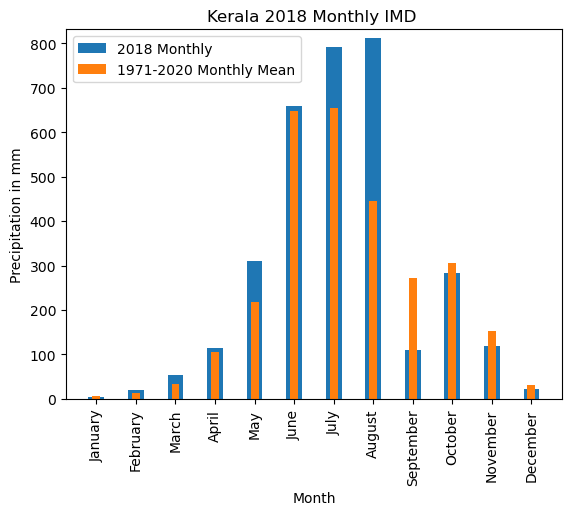

In [41]:
plt.bar(x_values, y1_values, width = 0.4, label = '2018 Monthly')
plt.bar(x_values, y2_values, width = 0.2, label = '1971-2020 Monthly Mean')
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',  'August', 'September', 'October', 'November', 'December'] 

# Add labels and legend
plt.xlabel('Month')

plt.xticks(x_values, months, rotation=90)
# Set the y-axis to start from 0
plt.ylim(0, max(y1_values) + 20)

plt.ylabel('Precipitation in mm')
plt.title('Kerala 2018 Monthly IMD ')
plt.legend()

# Show the plot
plt.show()

In [54]:
kerala_imd_monthly_2018_flatten

<xarray.DataArray 'RAINFALL' (month: 12)>
dask.array<mean_agg-aggregate, shape=(12,), dtype=float64, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 0
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [17]:
# Filter the dataset to include only monsoon months 6, 7, 8, 9
kerala_monsoon_imd = kerala_imd_ds.sel(TIME=kerala_imd_ds['TIME'].dt.month.isin([6, 7, 8]))

In [18]:
kerala_monsoon_2018_daily = kerala_monsoon_imd.mean(dim=['x', 'y'], skipna=True)
kerala_monsoon_2018_daily_max = kerala_monsoon_imd.max(dim=['x', 'y'], skipna=True)

In [20]:
kerala_monsoon_2018 = kerala_monsoon_imd.sum(dim=['TIME'], skipna=True)

/tmp/ipykernel_1816/179112651.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(district_gdf.geometry.centroid.x, district_gdf.geometry.centroid.y, district_gdf['DISTRICT']):


Text(0.5, 1.0, 'Kerala 2018 Monsoon Rainfall IMD')

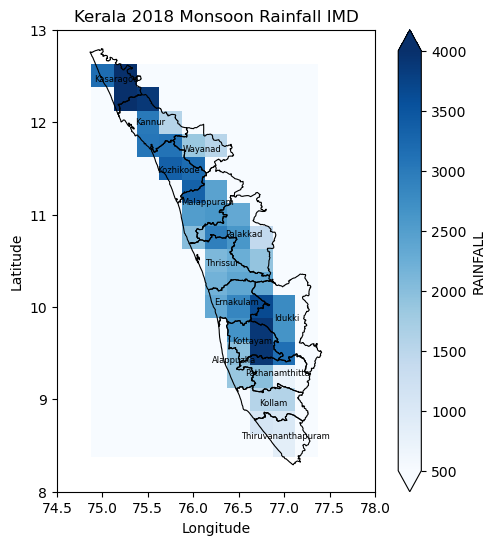

In [21]:
# Plot the raster data
fig, ax = plt.subplots(figsize=(6, 6))
district_gdf.boundary.plot(ax =ax, color='black',linewidth=0.8 )
kerala_monsoon_2018.plot(ax=ax, cmap='Blues', vmin=500, vmax=4000)
# Add labels for each district
for x, y, label in zip(district_gdf.geometry.centroid.x, district_gdf.geometry.centroid.y, district_gdf['DISTRICT']):
    ax.text(x, y, label, fontsize=6,color= 'black', ha='center', va='center')
ax.set_xlim([74.5, 78])  # Adjust the longitude range
ax.set_ylim([8, 13])   # Adjust the latitude range
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Kerala 2018 Monsoon Rainfall IMD')

In [22]:
kerala_monsoon_2018_daily_pd = kerala_monsoon_2018_daily.to_dataframe()
kerala_monsoon_2018_daily_max_pd = kerala_monsoon_2018_daily_max.to_dataframe()

In [23]:
np.max(kerala_monsoon_2018_daily_max_pd['RAINFALL'])

301.1153869628906

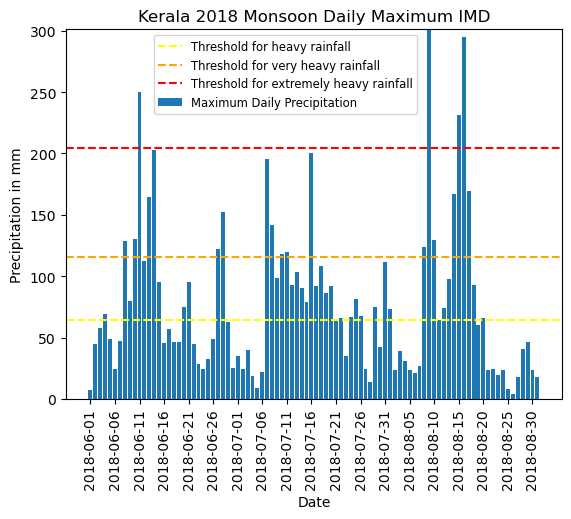

In [48]:
# Assume you want to use column 'x_column' as the x-axis and 'y_column' as the y-axis
y_column = 'RAINFALL'
x_column = 'TIME'

#y1_values = kerala_monsoon_2018_daily_pd[y1_column]
y2_values = kerala_monsoon_2018_daily_max_pd[y_column]

x_values = kerala_monsoon_2018_daily_max_pd.index.date


# Plot the data
#plt.bar(x_values, y1_values)
plt.bar(x_values, y2_values, label = 'Maximum Daily Precipitation')
# Add horizontal lines at y-values 64.5 and 115.5
plt.axhline(y=64.5, color='yellow', linestyle='--', label='Threshold for heavy rainfall')
plt.axhline(y=115.5, color='orange', linestyle='--', label='Threshold for very heavy rainfall')
plt.axhline(y=204.5, color='red', linestyle='--', label='Threshold for extremely heavy rainfall')


# Add labels and legend
plt.xlabel('Date')
plt.xticks(x_values[::5], x_values[::5], rotation=90)
# Set the y-axis to start from 0
plt.ylim(0, max(y2_values))

plt.ylabel('Precipitation in mm')
plt.title('Kerala 2018 Monsoon Daily Maximum IMD')
plt.legend(bbox_to_anchor=(0.72, 1), loc='upper right', fontsize='small')
plt.show()


In [13]:
heavy_precip = (kerala_monsoon_2018_daily_max_pd['RAINFALL'] > 64.5).sum()
very_heavy_precip = (kerala_monsoon_2018_daily_max_pd['RAINFALL'] > 115.5).sum()
extremely_heavy_precip = (kerala_monsoon_2018_daily_max_pd['RAINFALL'] > 204.5).sum()

In [14]:
heavy_precip,very_heavy_precip,extremely_heavy_precip

(48, 20, 4)